# ######################################################################
# Notebook for using showCamera to display ComCam images
# adapted from code originally written by Craig Lage.
# modified by Homer Neal
# ######################################################################

In [1]:
! eups list -s | grep lsst_distrib
! eups list -s | grep obs_lsst

lsst_distrib          g4213664e8e+b08e1c1b0b 	current w_2024_04 setup
obs_lsst              gbdc861c125+992a79d26a 	current w_2024_04 setup
obs_lsst_data         geee3bef3ea 	current w_2024_04 setup


In [2]:
import numpy as np
import matplotlib.pyplot as plt
#from lsst.daf.persistence import Butler
#from lsst.daf.butler import Butler
import lsst.daf.butler as db
import lsst.afw.cameraGeom.utils as camGeomUtils
import lsst.afw.display as afwDisplay

In [3]:
def myCallback(im, ccd, imageSource):
    """Assemble the CCD image.  Just bias subtraction and gain correction"""
    oim = camGeomUtils.rawCallback(im, ccd, imageSource,
                                       subtractBias=True, correctGain=True)
    return oim

checking visits
last visit = 2024030600002
['LSSTComCam/raw/all', 'LSSTComCam/calib/DM-28636/unbounded', 'LSSTComCam/calib/DM-28636', 'LSSTComCamSim/raw/all', 'LSSTComCam/calib/DM-33657', 'LSSTComCam/calib', 'LSSTComCam/calib/unbounded']
dataId:{'visit': 2024030600002, 'detector': 0, 'instrument': 'LSSTComCam', 'exposure': 2024030600002, 'collections': 'LSSTComCam/raw/all'}
EXPTIME: 5.0
Dim:(4608, 4096)
im[75,100]:  24740.0
len(im[*,10]):  4608


FileNotFoundError: [Errno 2] No such file or directory: '/home/hneal2/plots/img2024030600002-run-detsrange(0_2).png'

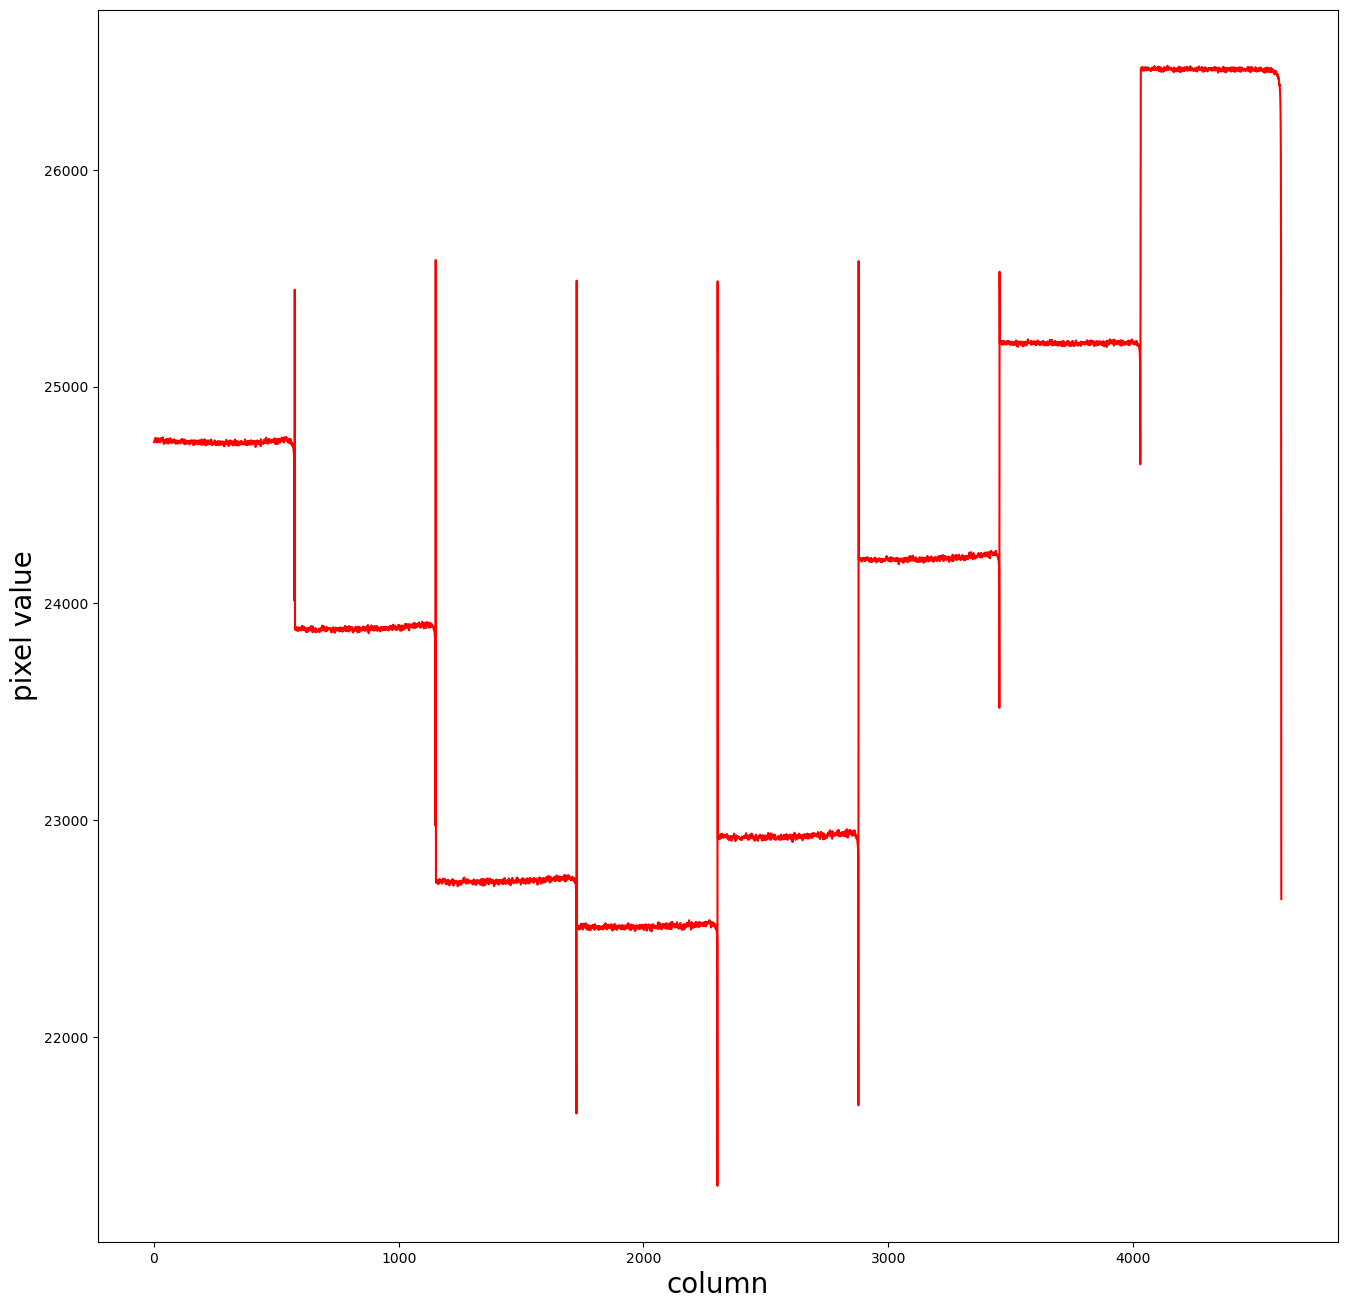

<Figure size 10000x10000 with 0 Axes>

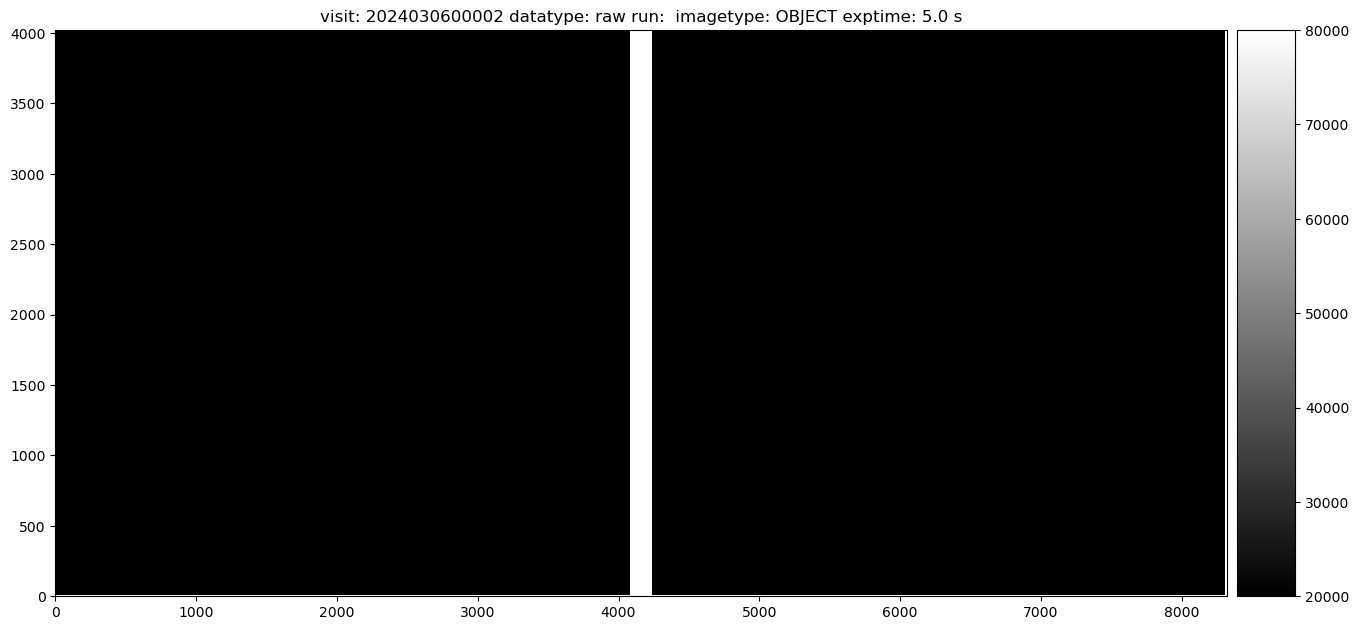

In [4]:
##### COMCAM REPO #########################################################
#REPO_DIR = '/lsstdata/offline/teststand/comcam/CCS/gen2repo_20201123/'
#REPO_DIR = '/lsstdata/offline/teststand/comcam/CCS/gen2repo/'
REPO_DIR = '/sdf/group/rubin/repo/oga/'
#/lsstdata/offline/teststand/comcam/CCS/gen2repo/raw/2020-07-27/2020072700026/
#REPO_DIR = '/lsstdata/offline/teststand/comcam/Archiver/gen2repo/'

# ATS
#REPO_DIR = '/lsstdata/offline/teststand/auxTel/DAQ/gen2repo_20191204/'


#SLAC, TS8	/gpfs/slac/lsst/fs3/g/data/datasets/ts8
#SLAC, BOT (testing)	/gpfs/slac/lsst/fs3/g/data/datasets/bot
#NCSA, TS8 (testing?)/datasets/ts8/repo
#NCSA, BOT (Run 3)	/project/production/tmpdataloc/BOT/gen2repo
    
#############################################################################3

butler = db.Butler("/repo/oga")
camera =  butler.get("camera", instrument="LSSTComCam", collections="LSSTComCam/calib")

#butler = Butler(REPO_DIR)
#visit = 3020030300064
print('checking visits')

run = ''
#run = '12624'
imagetype = 'FLAT'
testtype = 'FLAT'

#######################################
# Sensor range
#DNL=[196,197,198] # causes crash
#DNL=range(27,161)
#DNL=None
DNL=range(0,2)
#DNL=range(27,36)
#DNL=[4]


######################################


#imagetype = 'DARK'
#testtype = 'DARK'

#visits = butler.queryMetadata('raw', ['visit'], dataId={'imageType': 'FLAT', 'testType': 'FLAT', 'run': '6806D'})
#visits = butler.queryMetadata('raw', ['visit'], dataId={'imageType': imagetype, 'testType': testtype, 'run': run})
#visits = butler.queryMetadata('raw', ['visit'], dataId={'imageType': 'FLAT'})
#visits = butler.queryMetadata('raw', ['visit'])
#print(visits[-20:-1])

# take the last visit
#visit=visits[-1]

# comcam 20201123
#visit = 3020122800007
visit = 2024030600002

print("last visit = "+str(visit))

dataId = dict(visit=visit)
#, detector=94)





###############################
collections = butler.registry.queryCollections(f"*ComCam*")
print(collections)


#dataId = {'instrument':'LSSTComCam', 'collections':'LSSTComCam/raw/all'}
#dataId = {'collections':'LSSTComCam/raw/all'}
#dataId = {'instrument':'LSSTComCam'}
#camera = butler.get('camera',**dataId)


dataId = {'visit':visit, 'detector':0, 'instrument':'LSSTComCam', 'exposure':2024030600002, 'collections':'LSSTComCam/raw/all'}
print('dataId:'+str(dataId))

calexp = butler.get('raw',**dataId)
md = calexp.getMetadata()
#print('md: \n'+str(md))
try:
    print('RUNNUM: '+md['RUNNUM'])
except:
    pass

print('EXPTIME: '+str(md['EXPTIME']))

mdtesttype=md['TESTTYPE']
mdimagetype=md['IMGTYPE']

#psf = calexp.getPsf()
#wcs = calexp.getWcs()

masked_image = calexp.getMaskedImage()
im = masked_image.getImage()
print('Dim:'+str(im.getDimensions()))
print('im[75,100]: ',im[75,100])
print('len(im[*,10]): ',im.getDimensions()[0])
xs = []
ys = []
for x in range(0,im.getDimensions()[0]-1):
    xs.append(x)
    ys.append(im[x,1750])

figp, axs = plt.subplots(1, 1, figsize=(16, 16))
        
    
plt.figure(figsize=(16,16))
plt.plot(xs, ys, c='r')
plt.xlabel('column', fontsize=20)
plt.ylabel('pixel value', fontsize=20)
###############################



fig = plt.figure(figsize=(100,100))
disp = afwDisplay.Display(1, "matplotlib")

#disp.scale('linear', min=100.0, max=250.0)
disp.scale('linear', min=20000.0, max=80000.0)

dataType='raw'

mos = camGeomUtils.showCamera(camera, \
                              camGeomUtils.ButlerImage(butler, dataType, visit=dataId["visit"], \
                                                        verbose=False, callback = myCallback,\
                                                      background = np.nan),\
                              binSize=1,\
                              detectorNameList=DNL,\
                              display=disp, overlay=False, \
                              title="visit: %d datatype: %s run: %s imagetype: %s exptime: %s s" % (visit, dataType,run,mdimagetype,str(md['EXPTIME'])))
if DNL is not None :
    dets = str(DNL).replace(", ","_").replace("[","").replace("]","")
else:
    dets = "all"
fig.savefig('/home/hneal2/plots/img%d-run%s-dets%s.png' % (visit,run,dets))

In [7]:
!ls -lrt /lsstdata/offline/teststand/comcam/CCS/gen2repo

ls: cannot access /lsstdata/offline/teststand/comcam/CCS/gen2repo: No such file or directory


In [ ]:
ls -lrt /lsstdata/offline/teststand/comcam/CCS/*2020072*/registry*

In [ ]:
!fold /lsstdata/offline/teststand/comcam/Archiver/gen2repo/raw/2020-07-27/2020072700019/2020072700019-R22-S00-det000.fits | grep -i dark

In [9]:
!ls -lrt /lsstdata/offline/teststand/comcam/CCS/gen2repo/raw/2022-01-18/2022011800027


total 5
lrwxrwxrwx 1 55827 202 115 Jan 18 23:33 2022011800027-R22-S10-det003.fits -> /lsstdata/offline/instrument/LSSTComCam-ccs/storage/20220118/CC_O_20220118_000027/CC_O_20220118_000027_R22_S10.fits
lrwxrwxrwx 1 55827 202 115 Jan 18 23:33 2022011800027-R22-S11-det004.fits -> /lsstdata/offline/instrument/LSSTComCam-ccs/storage/20220118/CC_O_20220118_000027/CC_O_20220118_000027_R22_S11.fits
lrwxrwxrwx 1 55827 202 115 Jan 18 23:33 2022011800027-R22-S12-det005.fits -> /lsstdata/offline/instrument/LSSTComCam-ccs/storage/20220118/CC_O_20220118_000027/CC_O_20220118_000027_R22_S12.fits
lrwxrwxrwx 1 55827 202 115 Jan 18 23:33 2022011800027-R22-S20-det006.fits -> /lsstdata/offline/instrument/LSSTComCam-ccs/storage/20220118/CC_O_20220118_000027/CC_O_20220118_000027_R22_S20.fits
lrwxrwxrwx 1 55827 202 115 Jan 18 23:33 2022011800027-R22-S21-det007.fits -> /lsstdata/offline/instrument/LSSTComCam-ccs/storage/20220118/CC_O_20220118_000027/CC_O_20220118_000027_R22_S21.fits
lrwxrwxrwx 1 55827 202 115 

In [2]:
!ls -lrt /lsstdata/

total 0
drwxr-xr-x 3 root root 23 Oct 14 18:32 offline


In [5]:
!ls -lrt /project/production/tmpdataloc/BOT/storage/20201113/

ls: cannot access /project/production/tmpdataloc/BOT/storage/20201113/: No such file or directory


In [6]:
!ls -lrt /lsstdata/offline/teststand/comcam/Archiver/gen2repo/

total 4353
-rw-r--r--  1 55827 202      38 Jul 28 02:11 _mapper
drwxr-xr-x 60 55827 202    4096 Oct 15 16:01 raw
-rw-rw-r--  1 55827 202 4435968 Oct 15 16:34 registry.sqlite3


In [12]:
!fold /project/production/tmpdataloc/BOT/gen2repo/raw/2020-11-13/*0165/*det162* | grep -a -m 1 -i run

RUNNUM  = '12740   '           / The Run Number                                 
fold: write error: Broken pipe


In [14]:
!fold /lsstdata/offline/teststand/auxTel/DAQ/gen2repo_20191204/raw/2019-12-04/3019120400002-det000.fits | egrep -a -A 1 -i "ogp|pck_lowp"

           1709 / WREB config bias RD (applied)                  OGP     =      
           -2.0 / WREB config bias OG (requested)                OG      =      
--
            938 / WREB DAC SCLK High (applied)                   PCK_LOWP=      
           -8.0 / WREB DAC PCLK Low (requested)                  PCK_LOW =      


In [15]:
!fold /lsstdata/offline/teststand/auxTel/DAQ/gen2repo_20191204/raw/2019-12-04/3019120400002-det000.fits | head -30

SIMPLE  =                    T / Java FITS: Wed Nov 20 20:40:03 UTC 2019        
BITPIX  =                    8 / bits per data value                            
NAXIS   =                    0 / number of axes                                 
EXTEND  =                    T / Extensions are permitted                       
HEADVER =                    2 / Version number of header                       
DATE    = '2019-12-04T20:08:11.741' / Creation Date and Time of File            
DATE-OBS= '2019-12-04T20:08:09.239' / Date of the observation (image acquisition
MJD     =    58821.83902478032 / Modified Julian Date that the file was written 
MJD-OBS =   58821.838995821774 / Modified Julian Date of image acquisition      
INSTRUME= 'LATISS  '           / Instrument                                     
TELESCOP= 'LSST_AuxTelescope'  / Telescope                                      
IMAGETAG= '1575490089239'      / DAQ Image id                                   
CONTNUM = 'ffffffffffffffff'

In [8]:
!ls /lsstdata/offline/teststand/comcam/Archiver/gen2repo/raw/2021-08-19/2021081900016/2021081900016-R22-S01-det001.fits

/lsstdata/offline/teststand/comcam/Archiver/gen2repo/raw/2021-08-19/2021081900016/2021081900016-R22-S01-det001.fits
